In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [27]:
from pathlib import Path
import argparse
import wandb
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
# import hvplot.xarray

import tensorflow as tf
import tensorflow_datasets as tfd
import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from models.gp_tf import add_model_args, get_likelihood, get_kernel, get_inducing_points
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics
from smoke_test import add_winter_smoke_test_args, add_january_smoke_test_args

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Arguments

In [30]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"

# subset
args.feature_scaler = "standard"
args.model = "svgp"
args.smoke_test = False
args.wandb_mode = "disabled"
args.wandb_resume = True
args.id = None # "2uuq7tks"
args.batch_size = 2048
args.n_epochs = 10

args = add_january_smoke_test_args(args)
# args = add_winter_smoke_test_args(args)

### Logger


In [11]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

### Load Data

In [16]:
%%time

# load data
data = load_data(args)

# preprocess data
data = preprocess_data(data, args)

# feature transformation
data, scaler = feature_transform(data, args)

100%|██████████| 6/6 [00:00<00:00, 60.28it/s]


CPU times: user 552 ms, sys: 164 ms, total: 716 ms
Wall time: 718 ms


In [17]:
data[data.attrs["input_cols"]].head()

,longitude,latitude,time
0,1.600540,0.545403,-1.706420
1,1.598256,0.552926,-1.706420
2,1.595968,0.560448,-1.706419
3,1.593677,0.567970,-1.706418
4,1.591384,0.575492,-1.706418


In [18]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,2.835390e+05,2.835390e+05,2.835390e+05
mean,-4.498517e-13,9.988473e-15,-1.240917e-09
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.945946e+00,-1.642479e+00,-1.706420e+00
25%,-8.227600e-01,-8.426432e-01,-8.609840e-01
50%,5.412140e-02,-5.230742e-02,-2.617701e-02
75%,8.788459e-01,7.522707e-01,8.565812e-01
max,1.601480e+00,2.220775e+00,1.760150e+00


In [19]:
%%time


# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

print(args.n_train)
# if args.smoke_test:
    
rng = np.random.RandomState(args.split_seed)
idx = rng.choice(np.arange(args.n_train), size=2_000)
xtrain = xtrain[idx]
ytrain = ytrain[idx]

# rng = np.random.RandomState(args.split_seed+10)
# idx = rng.choice(np.arange(args.n_valid), size=1_000)
# xvalid = xvalid[idx]
# yvalid = yvalid[idx]

    
wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

255185
CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 71.4 ms


In [20]:
xtrain.shape

(2000, 3)

## Model - Stochastic Variational GP

In [21]:
import gpflow
import gpflux
import numpy as np
from gpflow.utilities import print_summary

# # Ensure TF does not see GPU and grab all GPU memory.
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2022-06-03 14:30:45.327455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-03 14:30:45.327507: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-03 14:30:45.327534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ige-meom-cal1): /proc/driver/nvidia/version does not exist


In [17]:
from scipy.cluster.vq import kmeans2

In [18]:
data_train = (xtrain.astype(np.float64), ytrain.astype(np.float64))

In [31]:
# get kernel
kernel = get_kernel(args)
# get likelihood
likelihood = get_likelihood(args)
# get inducing points
Z = get_inducing_points(xtrain, args)

In [ ]:
def make_svgp_model(n_inducing: int=100):
    # kernel function
    lengthscales = [1.0, 1.0, 7.0]
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=lengthscales,
    )

    # likelihood
    noise = 0.01
    likelihood = gpflow.likelihoods.Gaussian(variance=noise)

    # inducing points
    Z = kmeans2(xtrain, n_inducing, minit="points")[0]

    num_data = xtrain.shape[0]

    # create gp model
    model = gpflow.models.SVGP(kernel, likelihood, Z.astype(np.float64), num_data=num_data)
    
    return model

In [ ]:
# kernel function
lengthscales = [1.0, 1.0, 7.0]
kernel = gpflow.kernels.SquaredExponential(
    lengthscales=lengthscales,
)

# likelihood
noise = 0.01
likelihood = gpflow.likelihoods.Gaussian(variance=noise)

2022-06-02 00:05:19.342672: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
%%time

# inducing points
n_inducing = 100
Z = kmeans2(xtrain, n_inducing, minit="points")[0]

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 12.2 ms


In [ ]:
num_data = xtrain.shape[0]

# create gp model
model = gpflow.models.SVGP(kernel, likelihood, Z.astype(np.float64), num_data=num_data)

In [ ]:
# don't train the inducing inputs
gpflow.set_trainable(model.inducing_variable, False)

2022-06-02 00:05:19.554931: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [24]:
# compile
elbo = tf.function(model.elbo)

In [25]:


# tensor_data = tuple(map(tf.convert_to_tensor, data_train))
# elbo(tensor_data)  # run it once to trace & compile

In [26]:
# %%timeit
# elbo(tensor_data)

In [27]:
# Make dataloader, set batch size and prefetch buffer:
prefetch_buffer = 5
batch_size = 100

In [28]:
def make_ds(batch_size: int=100, shuffle: bool=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (xtrain.astype(np.float64), ytrain.astype(np.float64))
    )

    
    ds = ds.prefetch(prefetch_buffer)
    ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    
    
    return iter(ds)

ds_train = make_ds()
    

In [29]:
elbo(next(ds_train))

2022-06-02 00:05:23.047428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-02 00:05:23.051060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


<tf.Tensor: shape=(), dtype=float64, numpy=-100830.78823361931>

In [30]:
%%timeit
elbo(next(ds_train))

1.42 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
from tqdm.notebook import trange

In [32]:
losses = {}

In [33]:

# make dataset
ds_train = make_ds()

# make gp model
n_inducing = 100
model = make_svgp_model(n_inducing)
# don't train the inducing inputs
gpflow.set_trainable(model.inducing_variable, False)


# Create an Adam Optimizer
n_iterations = 10_000
losses["standard"] = []
optimizer = tf.optimizers.Adam()

# make training loss
training_loss = model.training_loss_closure(ds_train, compile=True)


@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)

with trange(n_iterations) as pbar:
    for step in pbar:
        optimization_step()
        elbo = -training_loss().numpy()
        losses["standard"].append(elbo)
        
        if step % 10 == 0:
            pbar.set_description(f"Loss (ELBO): {elbo:.4e}")
            
            

  0%|          | 0/10000 [00:00<?, ?it/s]

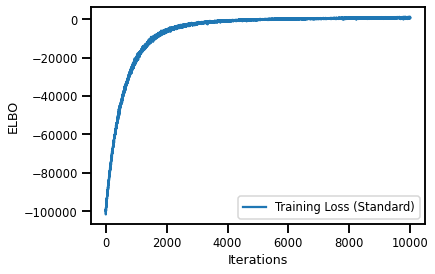

In [34]:
fig, ax = plt.subplots()

ax.plot(losses["standard"], label="Training Loss (Standard)")
ax.set(xlabel="Iterations", ylabel="ELBO")
plt.legend()
plt.show()

In [35]:
print_summary(model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤═════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                       │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪═════════════════════════════════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.0853100424625464                          │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼─────────────────────────────────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)          │ float64 │ [ 6.2871535   6.38146228 13.73560092]       │
├──────────────────────────┼───────────┼──────────────────┼─────

## Natural Gradients

In [36]:
from gpflow import set_trainable
from gpflow.optimizers import NaturalGradient

# make dataset
ds_train = make_ds()

# make gp model
n_inducing = 100
model = make_svgp_model(n_inducing)
# don't train the inducing inputs
gpflow.set_trainable(model.inducing_variable, False)


# Create an Adam Optimizer
n_iterations = 10_000
learning_rate = 1e-3

ordinary_adam_opt = tf.optimizers.Adam(learning_rate)


# NatGrads and Adam for SVGP
# Stop Adam from optimizing the variational parameters
set_trainable(model.q_mu, False)
set_trainable(model.q_sqrt, False)

# Create the optimize_tensors for SVGP
natgrad_adam_opt = tf.optimizers.Adam(learning_rate)

natgrad_opt = NaturalGradient(gamma=0.1)
variational_params = [(model.q_mu, model.q_sqrt)]


# make training loss
training_loss = model.training_loss_closure(ds_train, compile=True)

In [37]:
losses["natgrad"] = []
@tf.function
def optimization_step():
    natgrad_adam_opt.minimize(training_loss, var_list=model.trainable_variables)

@tf.function
def natgrad_optimization_step():
    natgrad_opt.minimize(training_loss, var_list=variational_params)
    
with trange(n_iterations) as pbar:
    for step in pbar:
        optimization_step()
        natgrad_optimization_step()
        elbo = -training_loss().numpy()
        losses["natgrad"].append(elbo)
        
        if step % 10 == 0:
            pbar.set_description(f"Loss (ELBO): {elbo:.4e}")

  0%|          | 0/10000 [00:00<?, ?it/s]

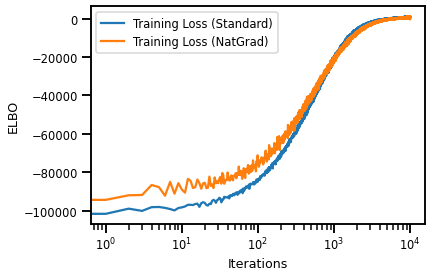

In [38]:
fig, ax = plt.subplots()

ax.plot(losses["standard"], label="Training Loss (Standard)")
ax.plot(losses["natgrad"], label="Training Loss (NatGrad)")
ax.set(xlabel="Iterations", ylabel="ELBO", xscale="log")
plt.legend()
plt.show()

In [39]:
print_summary(model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤═════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                       │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪═════════════════════════════════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.05200053763778622                         │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼─────────────────────────────────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)          │ float64 │ [ 5.30798236  5.36966031 12.82426735]       │
├──────────────────────────┼───────────┼──────────────────┼─────

In [40]:
import tensorflow_datasets as tfd

def predict_grid(gp_model, n_batches:int=5_000):
    # generate grid
    df_grid = generate_eval_data(args)
    
    # set input columns
    df_pred = df_grid[df_grid.attrs["input_cols"]].values
    
    # create dataloader
    ds_test = tf.data.Dataset.from_tensor_slices(df_pred).batch(n_batches)
    n_iters = len(ds_test)
    means, variances = [], []
    ds_test = iter(ds_test)
    with trange(n_iters) as pbar:
        for i in pbar:
            ix = next(ds_test)
            # predict using GP
            imean, ivar = gp_model.predict_f(ix)

            # add stuff
            means.append(imean)
            variances.append(ivar)

    mean = np.vstack(means)
    variance = np.vstack(variances)
    
    df_grid["pred"] = mean
    df_grid["variance"] = variance
    
    return df_grid
    

In [41]:
# make predictions
df_grid = predict_grid(model)

# create OI
ds_oi = postprocess_data(df_grid, args)

  0%|          | 0/17 [00:00<?, ?it/s]

/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/c

### Metrics

In [42]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)
print(rmse_metrics)

RMSE (Mean): 0.216
RMSE (Std): 0.061
NRMSE (Mean): 0.607
NRMSE (Std): 0.114
CPU times: user 296 ms, sys: 8 ms, total: 304 ms
Wall time: 289 ms


In [43]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

Resolved Scale: 799140606628042.500 (km)


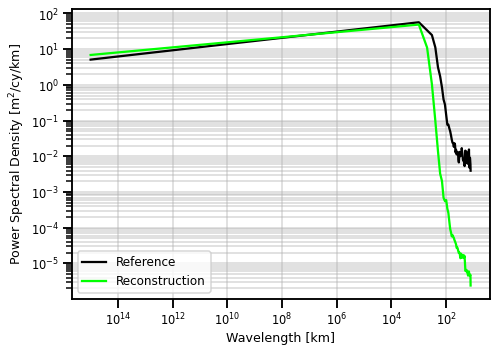

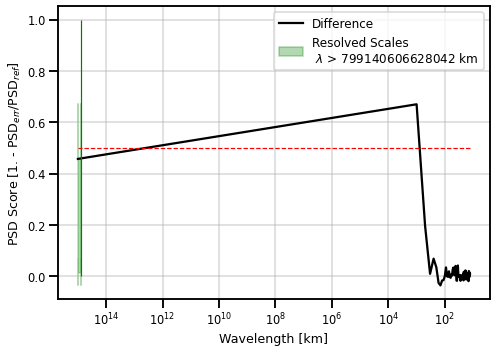

In [44]:

fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

### Viz

In [45]:
# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [46]:
# ds_oi.variance.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [47]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")


In [48]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

In [49]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")


In [86]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

In [50]:
from gpflux.helpers import construct_basic_inducing_variables, construct_basic_kernel

In [51]:
num_data = xtrain.shape[0]
input_dim = xtrain.shape[1]
num_inducing = 100
output_dim = ytrain.shape[1]


# kernel
kernel = construct_basic_kernel(gpflow.kernels.RBF(), output_dim)

# inducing points layer
inducing_vars = construct_basic_inducing_variables(
    num_inducing, 
    input_dim, 
    output_dim
)

# gp layer
gp_layer = gpflux.layers.GPLayer(
    kernel=kernel,
    inducing_variable=inducing_vars,
    num_data=num_data
)

# likelihood layer
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


# create DEEPGP
gp_model = gpflux.models.DeepGP(
    [gp_layer], 
    likelihood_layer,
    input_dim=input_dim
)

/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/helpers.py:121: UserWarning: No `z_init` has been specified in `construct_basic_inducing_variables`. Default initialization using random normal N(0, 1) will be used.
  warnings.warn(
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/tmp/ipykernel_5565/2358229022.py:25: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `

In [52]:
gpflux.__version__, tf.__version__, gpflow.__version__

('0.2.7', '2.5.3', '2.5.2')

In [53]:
optimizer = tf.optimizers.Adam()

@tf.function(autograph=False)
def objective_closure():
    return -gp_model.elbo((xtrain,ytrain))

@tf.function
def step():
    optimizer.minimize(objective_closure, gp_model.trainable_variables)

tq = tqdm.tqdm(range(args.n_epochs))
for i in tq:
    step()

  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


  0%|          | 0/10 [00:01<?, ?it/s]


ValueError: in user code:

    /tmp/ipykernel_5565/4031792773.py:9 step  *
        optimizer.minimize(objective_closure, gp_model.trainable_variables)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:528 minimize  **
        grads_and_vars = self._compute_gradients(
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:571 _compute_gradients
        loss = loss()
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:889 __call__
        result = self._call(*args, **kwds)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:933 _call
        self._initialize(args, kwds, add_initializers_to=initializers)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:763 _initialize
        self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/eager/function.py:3050 _get_concrete_function_internal_garbage_collected
        graph_function, _ = self._maybe_define_function(args, kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/eager/function.py:3444 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/eager/function.py:3279 _create_graph_function
        func_graph_module.func_graph_from_py_func(
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:999 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:672 wrapped_fn
        out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    /tmp/ipykernel_5565/4031792773.py:5 objective_closure
        return -gp_model.elbo((xtrain,ytrain))
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/models/deep_gp.py:202 elbo
        _ = self.call(X, Y, training=True)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/models/deep_gp.py:183 call
        f_outputs = self._evaluate_deep_gp(inputs, targets=targets, training=training)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/models/deep_gp.py:162 _evaluate_deep_gp
        features = layer(features, training=training)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py:230 __call__
        distribution, _ = super(DistributionLambda, self).__call__(
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:284 call  **
        outputs = super().call(inputs, *args, **kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py:236 call
        distribution, value = super(DistributionLambda, self).call(
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/keras/layers/core.py:919 call
        result = self.function(inputs, **kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py:176 _fn
        d = make_distribution_fn(*fargs, **fkwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:338 _make_distribution_fn
        return tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=tf.sqrt(cov))
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/decorator.py:232 fun
        return caller(func, *(extras + args), **kw)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py:346 wrapped_init
        default_init(self_, *args, **kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow/python/util/deprecation.py:535 new_func
        return func(*args, **kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/distributions/mvn_diag.py:268 __init__
        super(MultivariateNormalDiag, self).__init__(
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/decorator.py:232 fun
        return caller(func, *(extras + args), **kw)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py:346 wrapped_init
        default_init(self_, *args, **kwargs)
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/distributions/mvn_linear_operator.py:199 __init__
        batch_shape, event_shape = distribution_util.shapes_from_loc_and_scale(
    /home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/tensorflow_probability/python/internal/distribution_util.py:134 shapes_from_loc_and_scale
        raise ValueError(

    ValueError: Event size of `scale` (1) could not be broadcast up to that of `loc` (3).


In [54]:
gp_model.compile(tf.optimizers.Adam(0.01))

AttributeError: 'DeepGP' object has no attribute 'compile'

In [ ]:
history = gp_model.fit({"inputs": xtrain, "targets": ytrain}, epochs=int(10), verbose=1)

In [55]:
model = single_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

NameError: name 'single_layer_dgp' is not defined

In [56]:
num_data = xtrain.shape[0]
num_inducing = 100
output_dim = ytrain.shape[1]

kernel = gpflow.kernels.SquaredExponential()
z = np.linspace(xtrain.min(), xtrain.max(), num_inducing).reshape(-1, 1)
inducing_variable = gpflow.inducing_variables.InducingPoints(z)

# init gp layer
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

# likelihood layer
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


# create dgp
single_layer_dgp = gpflux.models.DeepGP([gp_layer], likelihood_layer)


/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_5565/1564550960.py:15: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


In [57]:
history = model.fit({"inputs": xtrain, "targets": ytrain}, epochs=int(10), verbose=1)


AttributeError: 'SVGP' object has no attribute 'fit'

In [58]:
plt.plot(history.history["loss"])

NameError: name 'history' is not defined

In [59]:
%%time


# model
model = get_model(args)

# optimizer
optimizer = get_optimizer(args)

# loss
make_step, val_step = get_loss_fn(args)

# init model
opt_state = optimizer.init(model)

ValueError: Unrecognized model: svgp

In [12]:
n_steps_per_epoch = args.n_train / args.batch_size
steps = int(n_steps_per_epoch * args.n_epochs) if not args.smoke_test else 500


wandb.config.update(
    {
        "steps": steps,
        "n_steps_per_epoch": n_steps_per_epoch,
    }
)

### Training

In [13]:
train_ds = make_mini_batcher(xtrain, ytrain, args.batch_size, 5, shuffle=True)
valid_ds = make_mini_batcher(xvalid, yvalid, args.batch_size, 5, shuffle=False)


losses = {} 
losses["train"] = []
losses["valid"] = []


with tqdm.trange(steps) as pbar:
    for step in pbar:
        
        ix, iy = next(train_ds)
        loss, grads = make_step(model, jnp.asarray(ix), jnp.asarray(iy))
        
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        losses["train"].append(loss)
        wandb.log({"train_loss": loss}, step=step)
        ix, iy = next(valid_ds)
        # validation step
        vloss = val_step(model, jnp.asarray(ix), jnp.asarray(iy))
        losses["valid"].append(vloss)
        
        
        wandb.log({"val_loss": vloss}, step=step)
        
        if step % 10 == 0:
            pbar.set_description(f"Step: {step:_} | Train Loss: {loss:.3e} | Valid Loss: {vloss:.3e}")
            


2022-05-31 10:21:56.474378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Step: 7_860 | Train Loss: 1.422e-02 | Valid Loss: 3.308e-02: 100%|██████████| 7866/7866 [16:35<00:00,  7.90it/s]


### Save models

In [23]:
# objects
path_model = Path(wandb.run.dir).joinpath("model.pickle")
path_scaler = Path(wandb.run.dir).joinpath("scaler.pickle")

# models to save
save_object(model, path_model)
save_object(scaler, path_scaler)

# save with wandb
wandb.save(str(path_model), policy="now")
wandb.save(str(path_scaler), policy="now")

### Load Models (Optional)

In [60]:
# # if args.server == "jz":
# # get id (from this run or a run you can set)
# run_id = wandb.run.id

# # initialize api
# api = wandb.Api()

# # get run
# run = api.run(f"{args.entity}/{args.project}/{run_id}")

# # download the files
# files = ["scaler.pickle", "model.pickle"]

# for ifile in files:
    
#     run.file(ifile).download(replace=True)

In [61]:
# model = load_object("./model.pickle")
# scaler = load_object("./scaler.pickle")

### PostProcessing

In [62]:
df_grid = generate_eval_data(args)
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)

df_grid.describe()

NameError: name 'scaler' is not defined

In [63]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe(), df_grid.describe()

NameError: name 'scaler' is not defined

In [64]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

NameError: name 'df_pred' is not defined

### Predictions


In [65]:
@jax.jit
def pred_step(model, data):
    return jax.vmap(model)(data)

In [66]:
from ml4ssh._src.model_utils import batch_predict
from functools import partial
import time

In [67]:
df_pred = jnp.asarray(df_pred[df_pred.columns.difference(["time"])].values)

fn = partial(pred_step, model)

t0 = time.time()
df_grid["pred"] = batch_predict(df_pred, fn, args.eval_batch_size)
t1 = time.time() - t0

NameError: name 'df_pred' is not defined

In [68]:
wandb.config.update(
    {
        "time_predict_batches": t1,
    }
)

NameError: name 't1' is not defined

In [69]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/c

KeyError: 'pred'

In [70]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 32)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-02-01
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 3 ... 84861 84862 84863
    vtime      (latitude, longitude, time) float64 31.0 32.0 33.0 ... 61.0 62.0
    pred       (latitude, longitude, time) float64 0.1331 0.1351 ... 0.09146
    variance   (latitude, longitude, time) float64 0.001586 ... 0.001367
    ssh        (latitude, longitude, time) float64 0.7328 0.7348 ... -0.08488
    ssh_grad   (latitude, longitude, time) float64 4.339e-05 ... 0.0006119
    ssh_lap    (latitude, longitude, time) float64 0.0009498 ... 0.001397

In [71]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

CPU times: user 304 ms, sys: 16 ms, total: 320 ms
Wall time: 306 ms


In [72]:
psd_metrics = get_psd_metrics(ds_oi, args)

### Figures

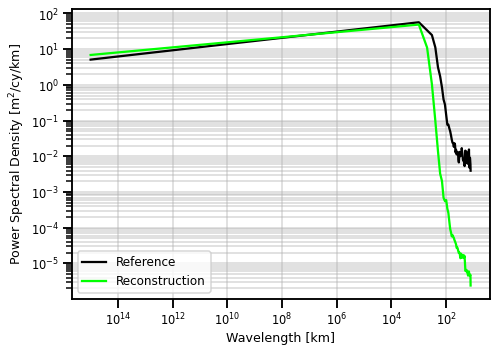

In [73]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

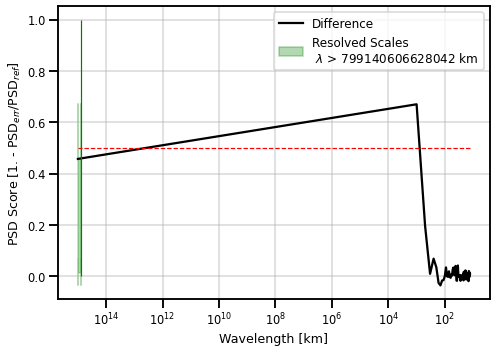

In [74]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [75]:
save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [76]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [77]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


In [78]:
# wandb.log(
#     {
#         "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
#     }
# )

### Gradients

In [79]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [80]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

In [81]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [82]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [83]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [84]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

In [85]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


In [86]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )